This notebook aims to implement the two copula based strategies from research papers (seen later). The heavy lifting calculations are conducted using the `pyvinecopulib` library. If you have *any* feedback, or have any experience with this type of programming, i would love for you to contact me! 

first we import dependencies

In [1]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import plotly.offline as pyo
import numpy as np
import seaborn as sns
import scipy.stats as stats

pyo.init_notebook_mode(connected=True)

pd.options.plotting.backend = 'plotly'

# set the seed incase
np.random.seed(42)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt

import scipy.stats as stats
import pyvinecopulib as pv

In [2]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData

In [3]:
# importing and formatting data to be readable from a list of top 50 asx mining companies 
df = pd.read_csv('mining_stocks.txt', sep='\t')
codes = df.drop(columns=['0.','Company','Market Cap', 'Share Price', '.91', '%_Change'])
stocks = list(codes['Code'])
stocks = [stock[4:] for stock in stocks]

stocks[0:10]

['BHP', 'FMG', 'RIO', 'NCM', 'JHX', 'S32', 'PLS', 'MIN', 'NST', 'AMC']

In [4]:
#fixing error
import yfinance as yfin
yfin.pdr_override()

end = dt.datetime(2023, 1, 1)
start = dt.datetime(2013,1,1)

stocksax = [stock + '.AX' for stock in stocks]

data = get_data(stocksax, start, end)
# drop all columns with nan values
data = data.dropna(axis=1)
data.head()

[*********************100%%**********************]  50 of 50 completed


,A4N.AX,ABC.AX,AKE.AX,AMC.AX,AVZ.AX,AWC.AX,AZS.AX,BGL.AX,BHP.AX,BKW.AX,...,PLS.AX,PRU.AX,RIO.AX,RMS.AX,RRL.AX,SFR.AX,SGM.AX,SMR.AX,SYA.AX,ZIM.AX
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.034909,3.12,1.593411,7.317752,0.020843,0.930,0.358340,0.086326,35.359264,11.60,...,0.029,2.087932,67.620003,0.458252,5.23,8.80,9.57,0.194117,0.162577,8.5
2013-01-03,0.034909,3.20,1.583452,7.398561,0.020843,0.950,0.378248,0.087244,35.648941,11.67,...,0.029,2.176991,69.250000,0.468214,5.33,8.94,9.86,0.184411,0.162577,8.5
2013-01-04,0.033939,3.20,1.568514,7.371625,0.020843,0.950,0.358340,0.087244,35.424675,11.80,...,0.029,2.127514,68.550003,0.453271,5.11,8.82,9.59,0.184411,0.162577,8.6
2013-01-07,0.033939,3.19,1.493823,7.371625,0.020843,0.955,0.358340,0.087244,35.331230,11.85,...,0.029,2.087932,67.400002,0.458252,4.99,8.74,9.67,0.189264,0.162577,8.6
2013-01-08,0.030060,3.26,1.478884,7.452434,0.020843,0.980,1.274100,0.087244,35.041553,11.90,...,0.029,2.058246,66.599998,0.473195,5.05,8.63,9.52,0.184411,0.162577,8.7


convert to log returns

In [5]:
# https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe
# why: https://www.analystforum.com/t/log-returns-when-calculating-correlation/56712

def log_ret(df, var='Price'):
    return np.log(df[var]) - np.log(df[var].shift(1))

find the kendall tau of the stocks, this is how we will measure the best pair to trade

In [6]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']
def kendall_tau(S1, S2): 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy-stats-kendalltau

    # calculate log returns and drop nan at start
    x = (np.log(S1) - np.log(S1.shift(1)))[1:]
    y = (np.log(S2) - np.log(S2.shift(1)))[1:]
    #print(x.head(),y.head())
    return stats.kendalltau(x,y)
kendall_tau(S1, S2)
#print(np.log(df) - np.log(df.shift(1)))

SignificanceResult(statistic=0.6458066534038226, pvalue=0.0)

now we will find the tau and pvalue of all the stocks

In [7]:
# return a matrix so i can make a nice graph
def find_kendall_pairs(data):
    # number of stocks
    n = len(data.columns)
    tau_matrix = np.zeros((n,n))
    pvalue_matrix = np.zeros((n,n))
    stocks = list(data.columns)
    # pairs = []
    for i in range(n):
        for j in range (i+1, n): # to avoid starting with the same stock
            S1 = data[stocks[i]]
            S2 = data[stocks[j]]
            # get the values
            tau, pvalue = kendall_tau(S1, S2)
            # append to matricies
            tau_matrix[i, j] = tau
            pvalue_matrix[i, j] = pvalue
    return tau_matrix, pvalue_matrix

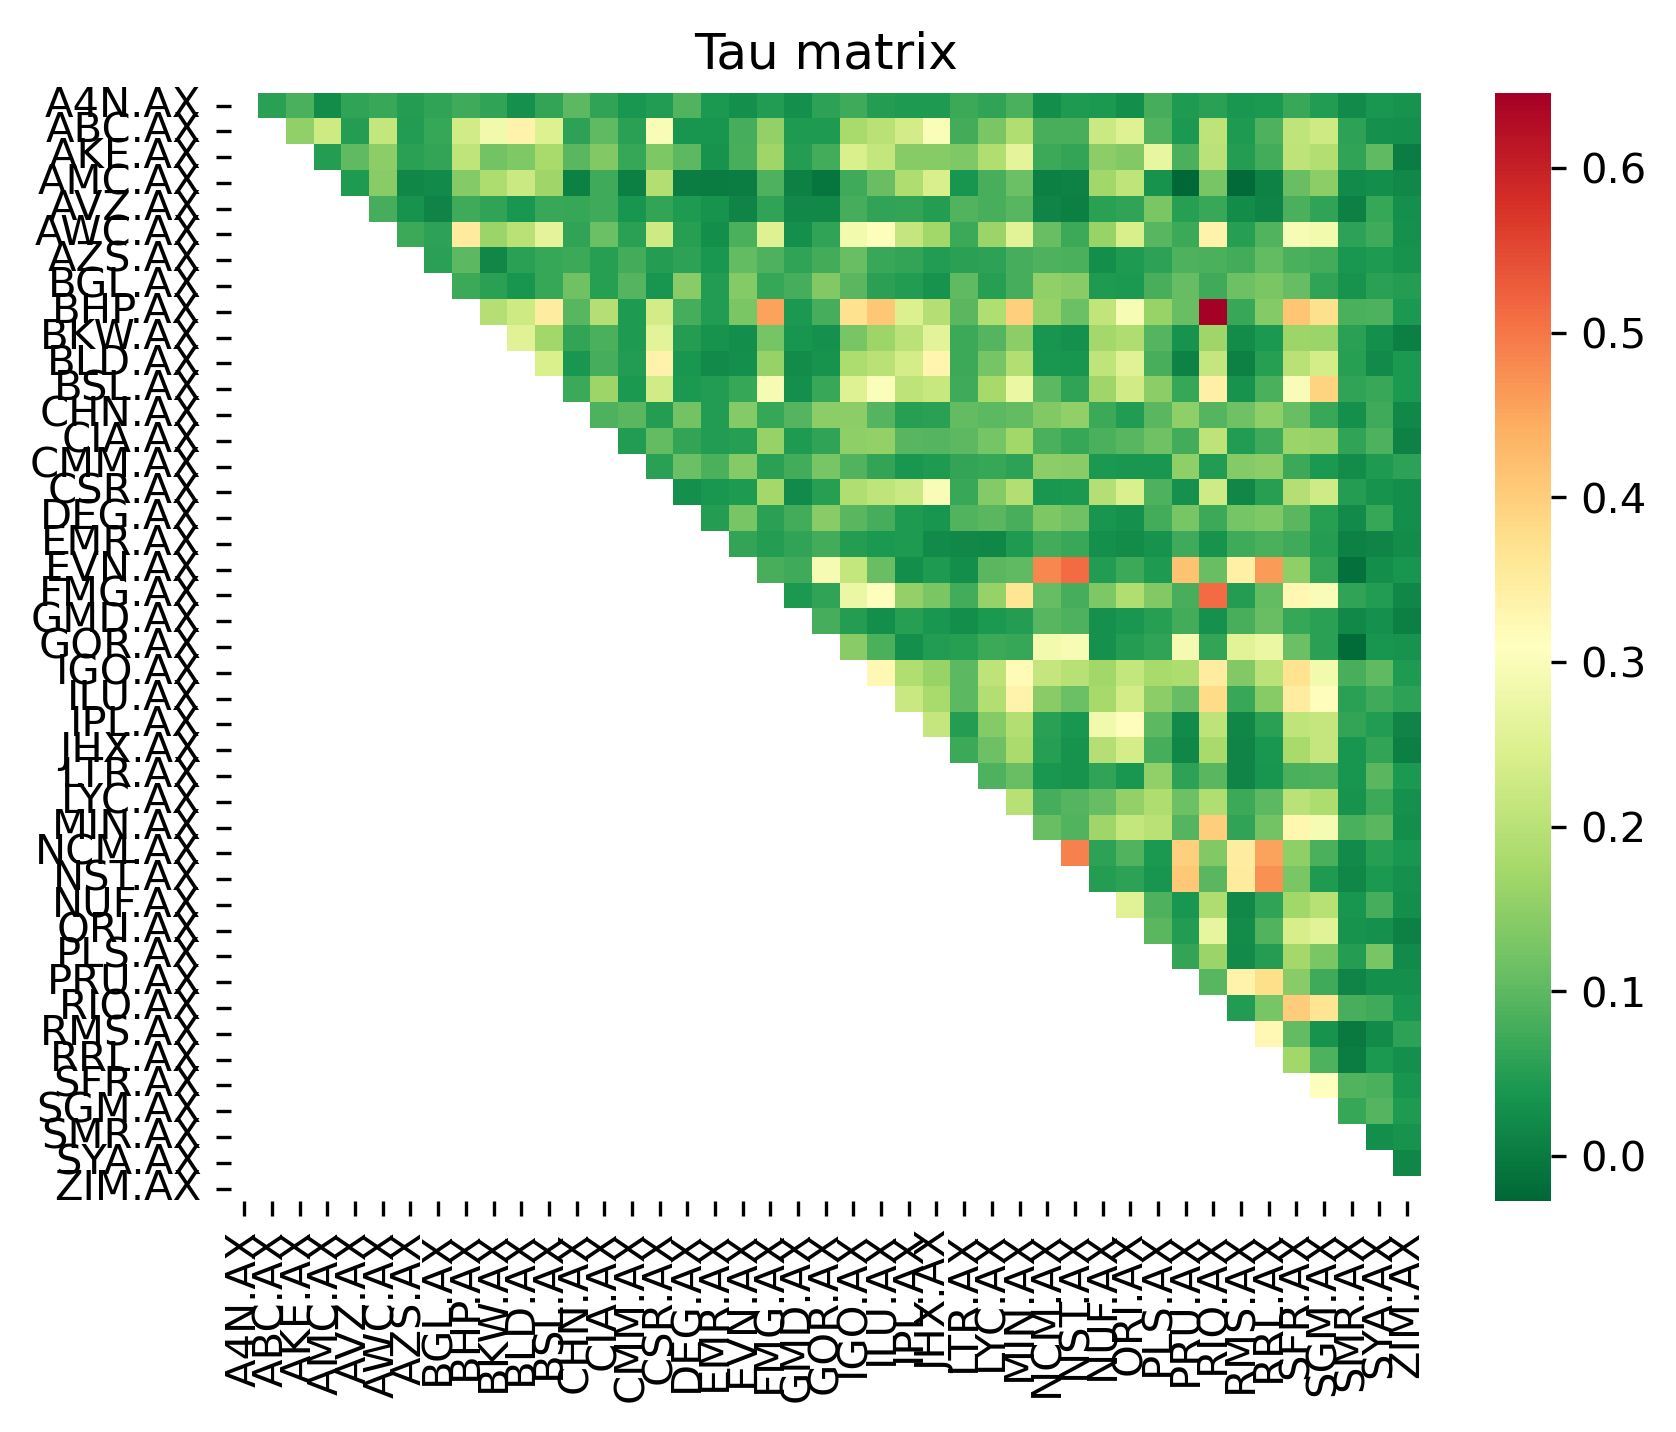

In [8]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

tau_matrix, pvalue_matrix = find_kendall_pairs(data)
stockNames = list(data.columns)

m = [0,0.2,0.4,0.6,0.8,1]
# heatmap of pvalues
# seaborn.heatmap(pvalues, xticklabels=stockNames, 
#                 yticklabels=stockNames, cmap='RdYlGn_r' 
#                 , mask = (pvalues >= 0.98)
#                 )
# heatmap of tau with pvalue mask
sns.heatmap(tau_matrix, xticklabels=stockNames, 
                yticklabels=stockNames, cmap='RdYlGn_r' 
                , mask = (tau_matrix == 0)
                )
plt.title('Tau matrix')
plt.show()

from this it is clear that BHP and RIO are the most related by far.

lets plot their two timeseries together

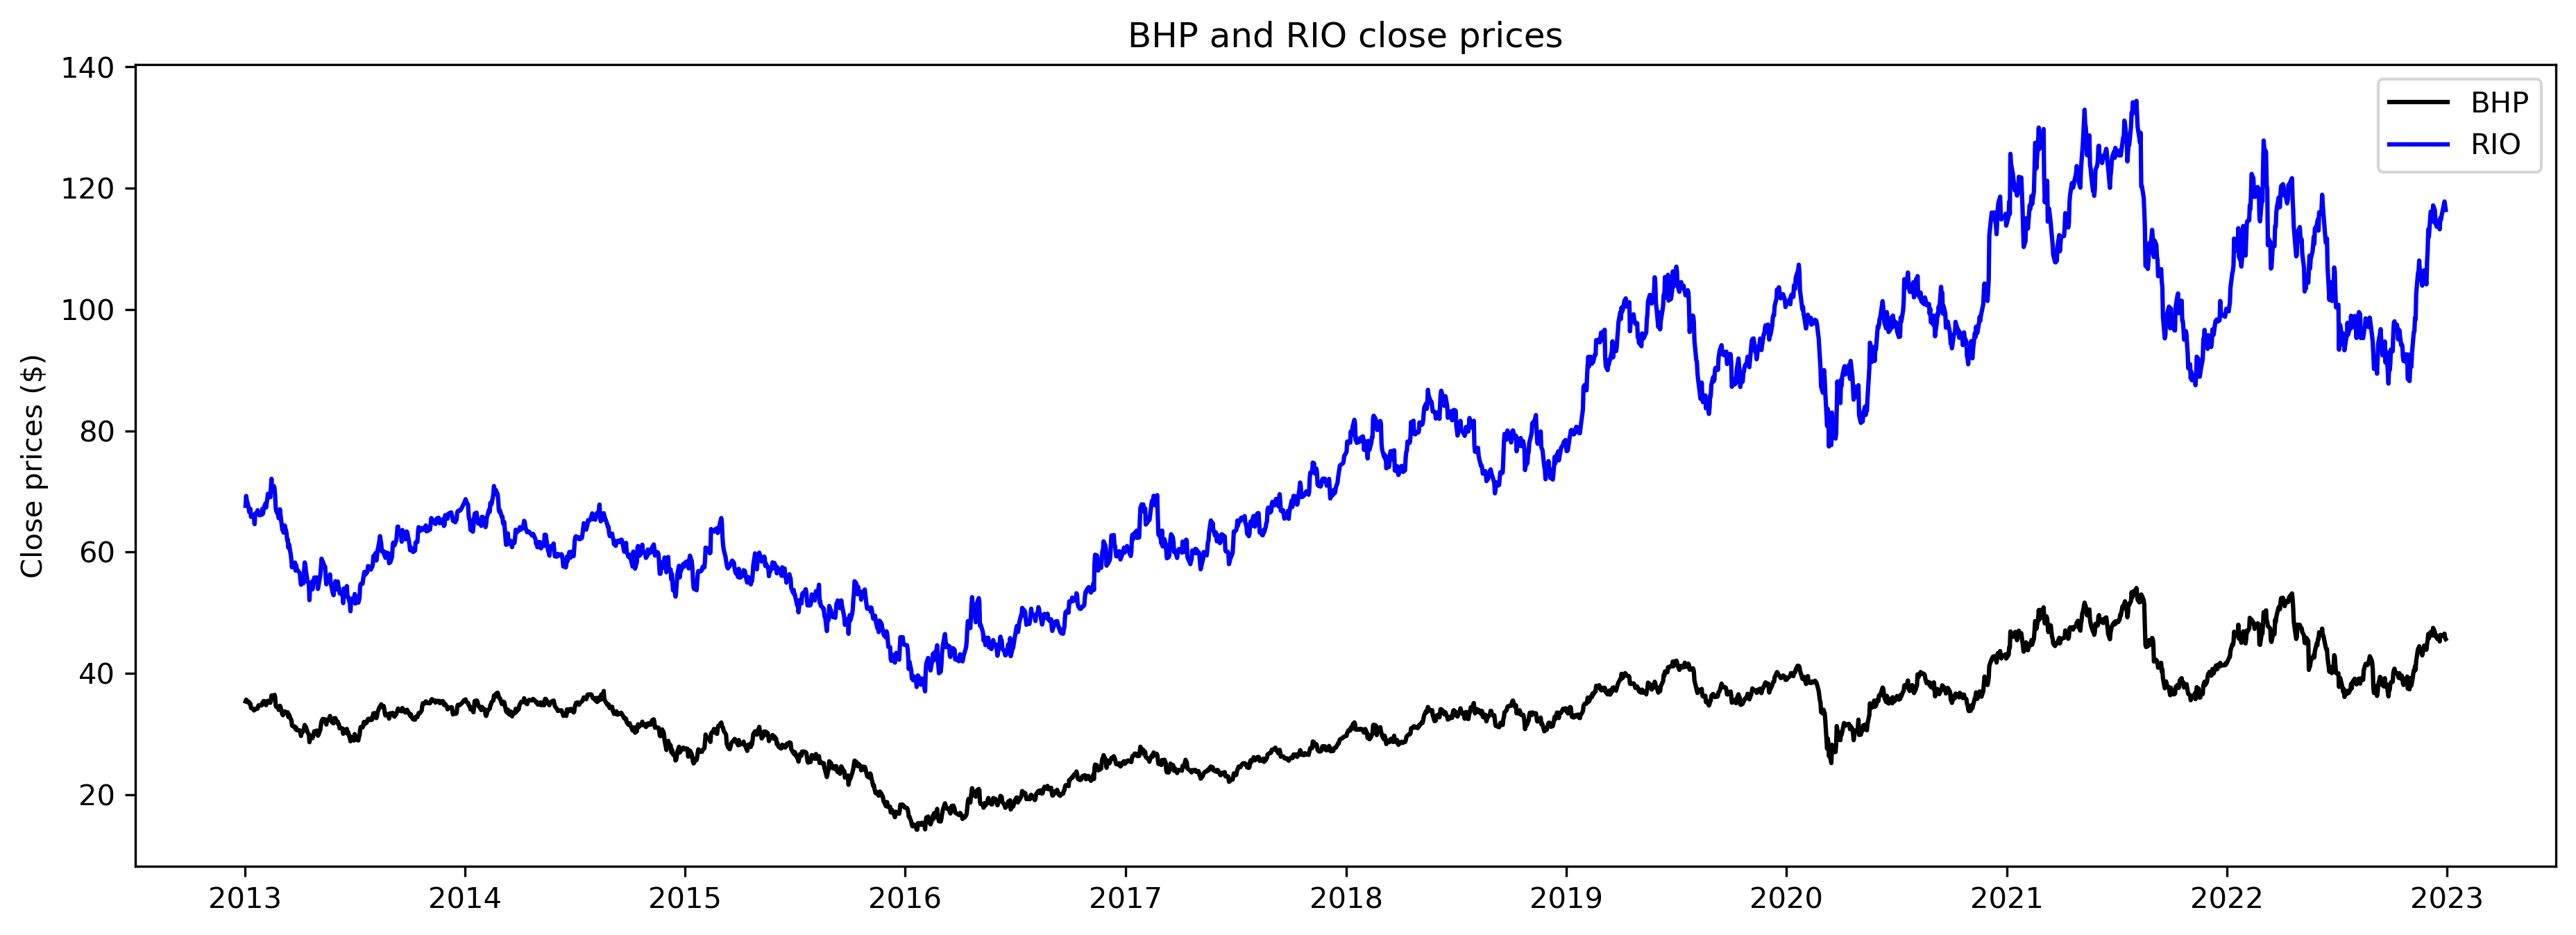

In [9]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(data.index, data["BHP.AX"], color='black')
plt.plot(data.index, data["RIO.AX"], color='blue')


plt.legend(['BHP', 'RIO'])
plt.title('BHP and RIO close prices')
plt.ylabel('Close prices ($)')
plt.show()

and their log returns:

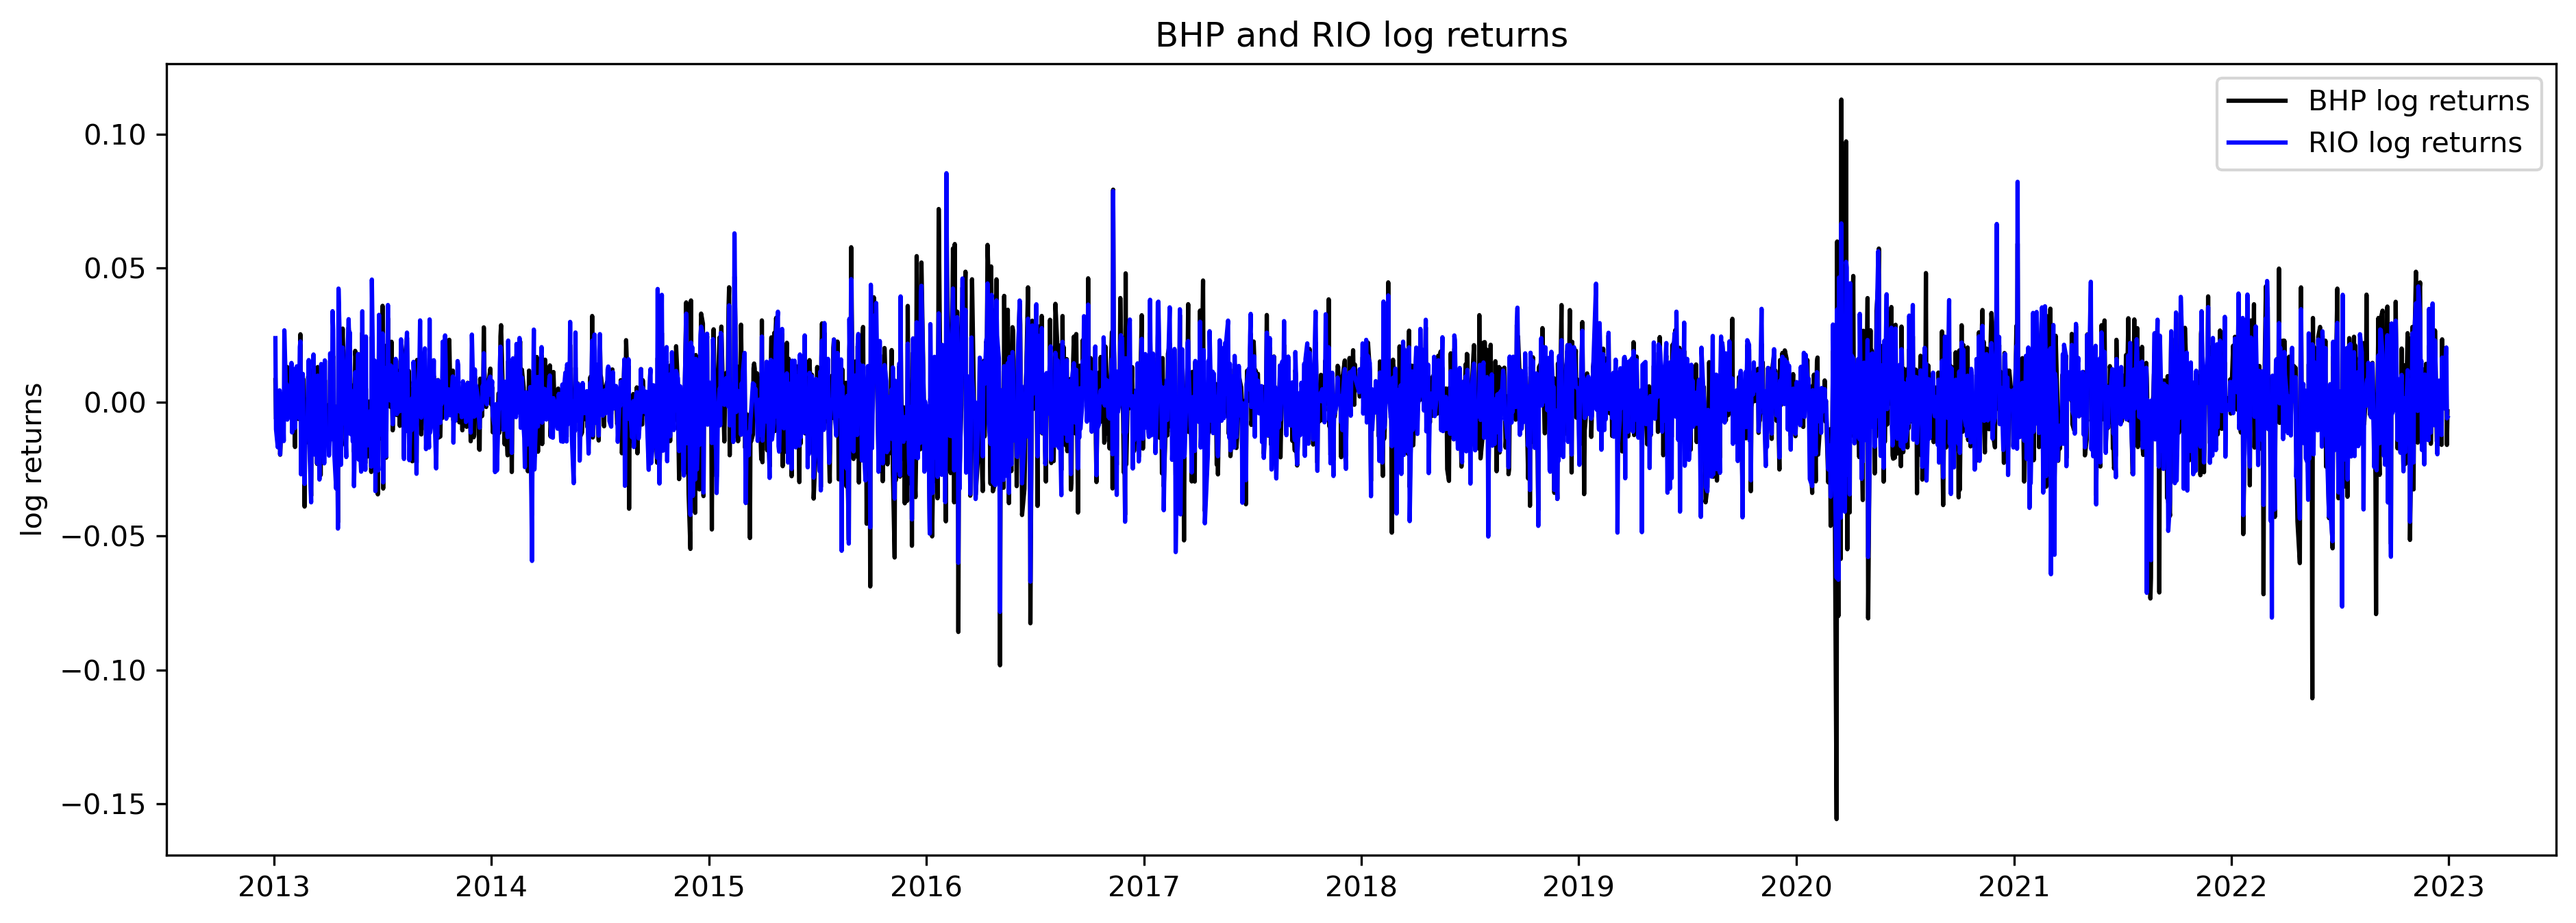

In [10]:
x = (np.log(data["BHP.AX"]) - np.log(data["BHP.AX"].shift(1)))
y = (np.log(data["RIO.AX"]) - np.log(data["RIO.AX"].shift(1)))

plt.figure(figsize=(15,5))
plt.plot(x.index, x, color='black')
plt.plot(y.index, y, color='blue')


plt.legend(['BHP log returns', 'RIO log returns'])
plt.title('BHP and RIO log returns')
plt.ylabel('log returns')
plt.show()

now to fit a copula to them, we need to convert the log returns into cumilative distributions. This can be done using pyvinecopulib's `to_pseudo_obs` feature (https://vinecopulib.github.io/pyvinecopulib/)

In [11]:
S1 = data['BHP.AX']
S2 = data['RIO.AX']

def get_variables(S1, S2): # drops the first term
    x = (np.log(S1) - np.log(S1.shift(1)))[1:]
    y = (np.log(S2) - np.log(S2.shift(1)))[1:]
    # combine them into one array and transpose to make columns
    xy = np.array([x, y]).T
    # get the empirical distribution
    u = pv.to_pseudo_obs(xy)
    return x, y, u
x, y, u = get_variables(S1, S2)

u[:5]

array([[0.69470774, 0.92456556],
       [0.328594  , 0.24407583],
       [0.42259084, 0.14099526],
       [0.27725118, 0.21208531],
       [0.55766193, 0.57187994]])

an example of fitting a copula using the data

In [12]:
def get_model(u):
    model = pv.Bicop(data=u)
    return model
get_model(u)

<pyvinecopulib.Bicop>
Student, parameters = 0.843485
 5.56427

What does the copulas look like?

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:11

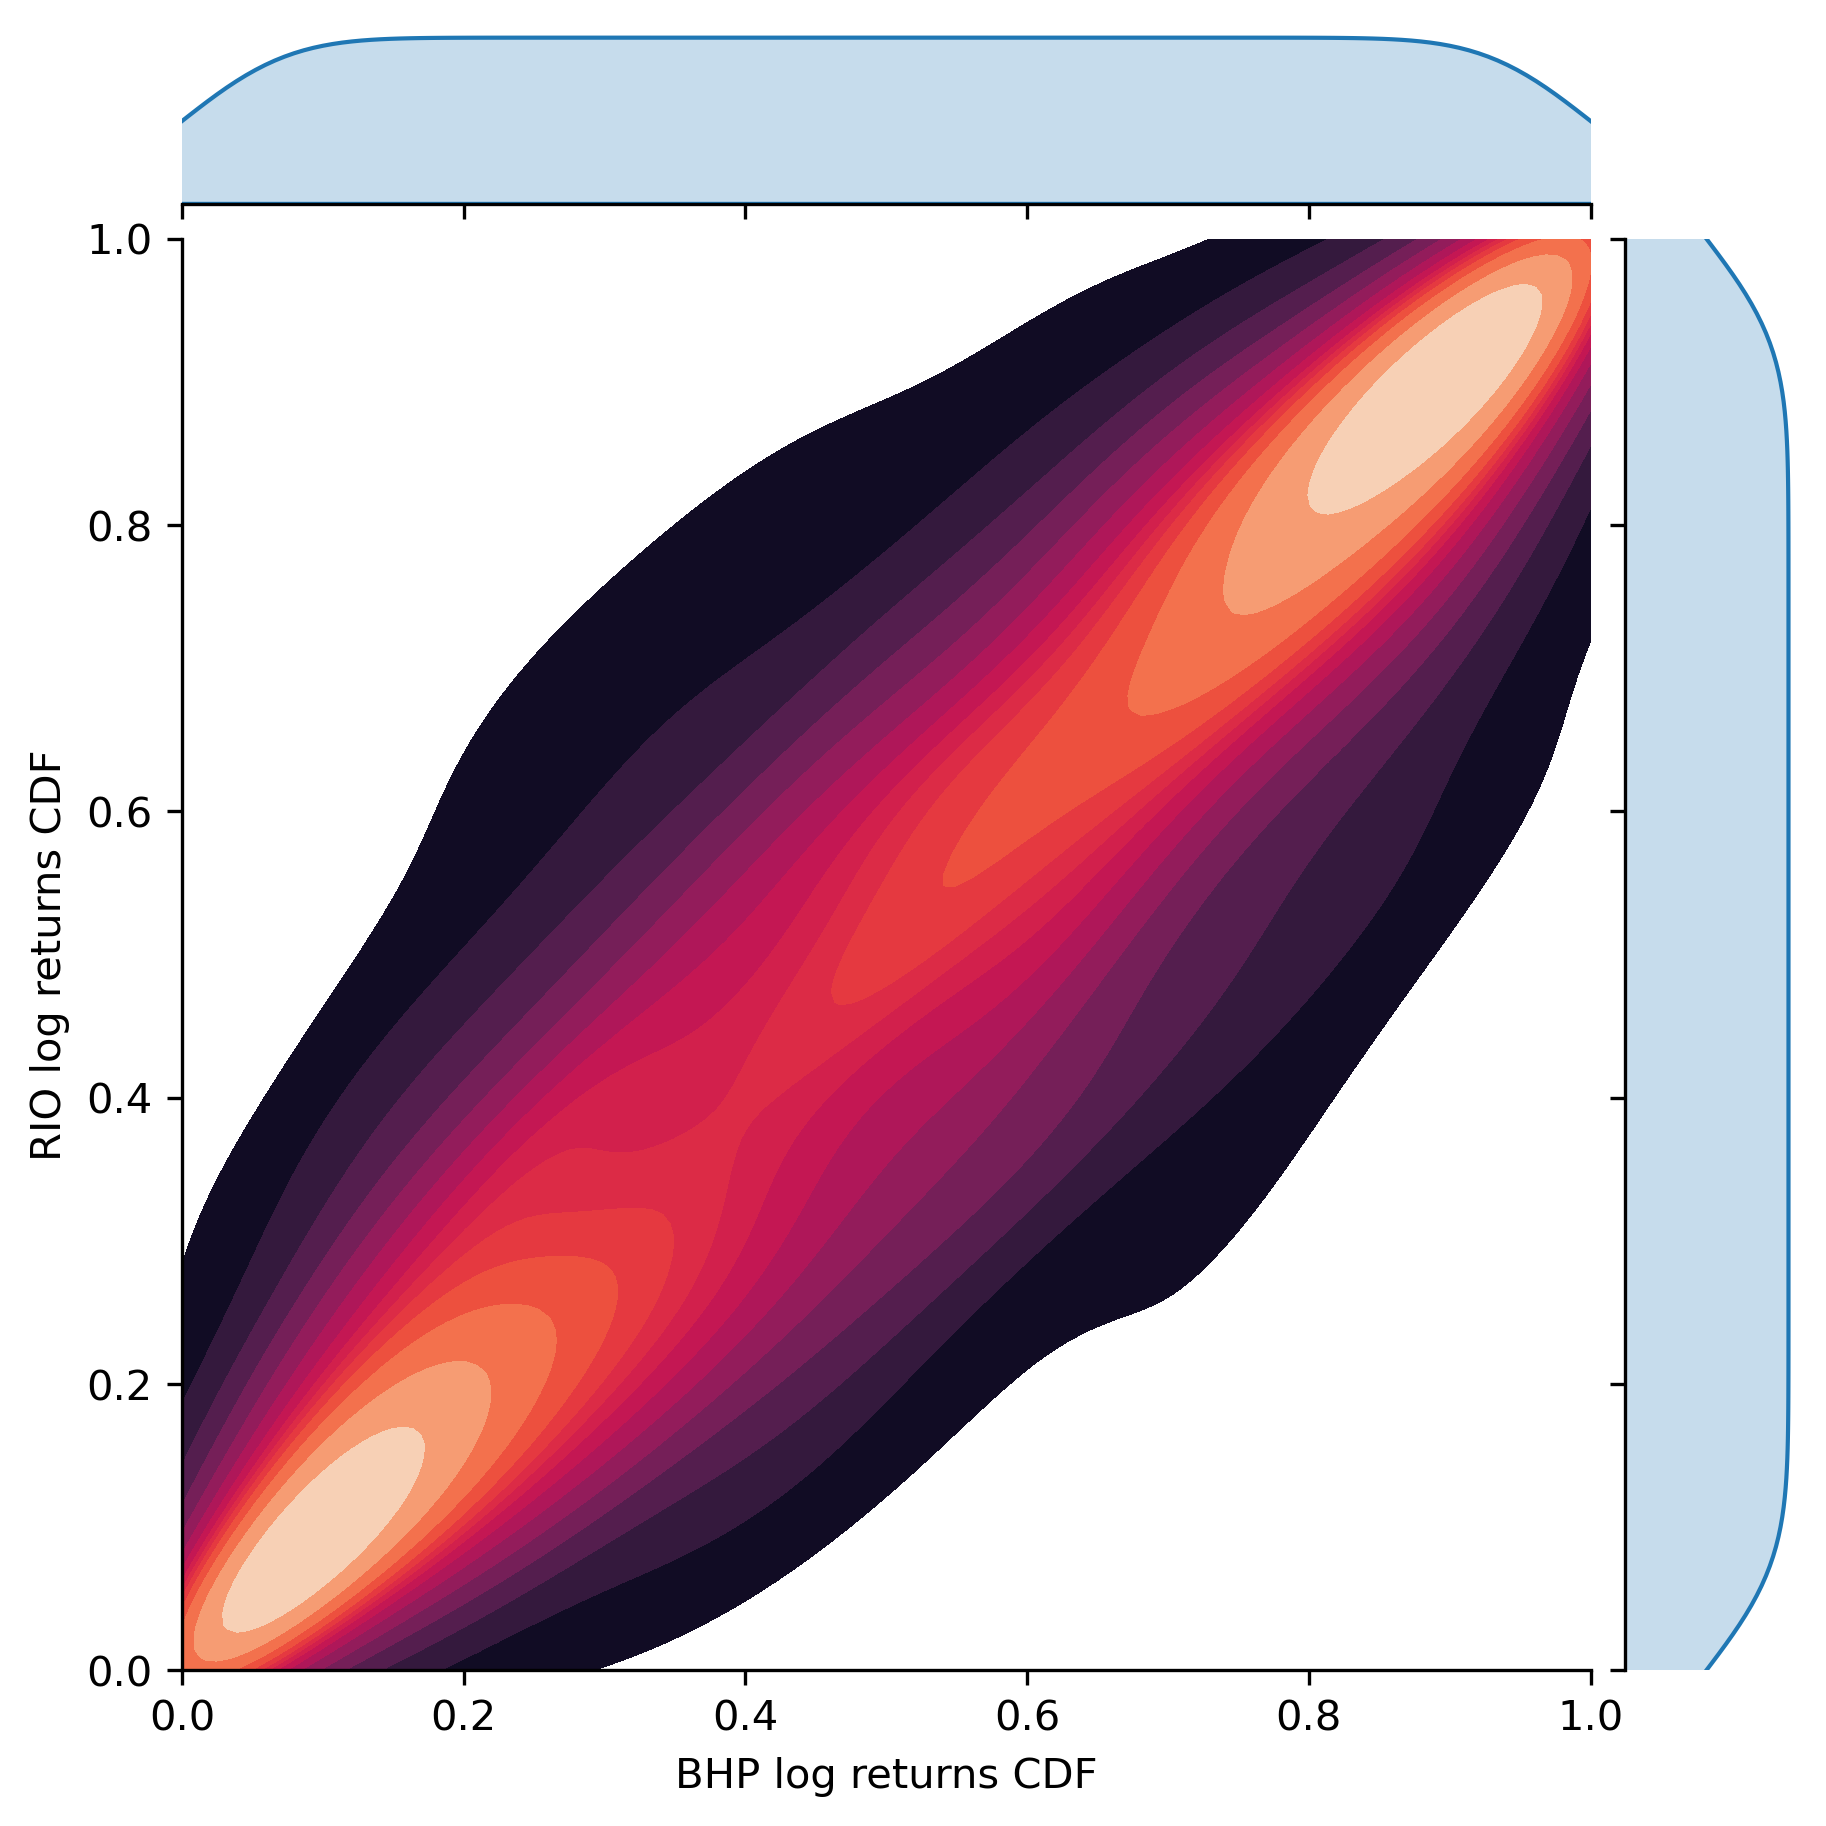

In [13]:
h = sns.jointplot(x=u.T[0], y=u.T[1], kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = h.set_axis_labels("BHP log returns CDF", "RIO log returns CDF")

above is what the actual stock data looks like, below is what the fitted model looks like. As you can see they look quite similar, and the copula models the tail quite well 

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:11

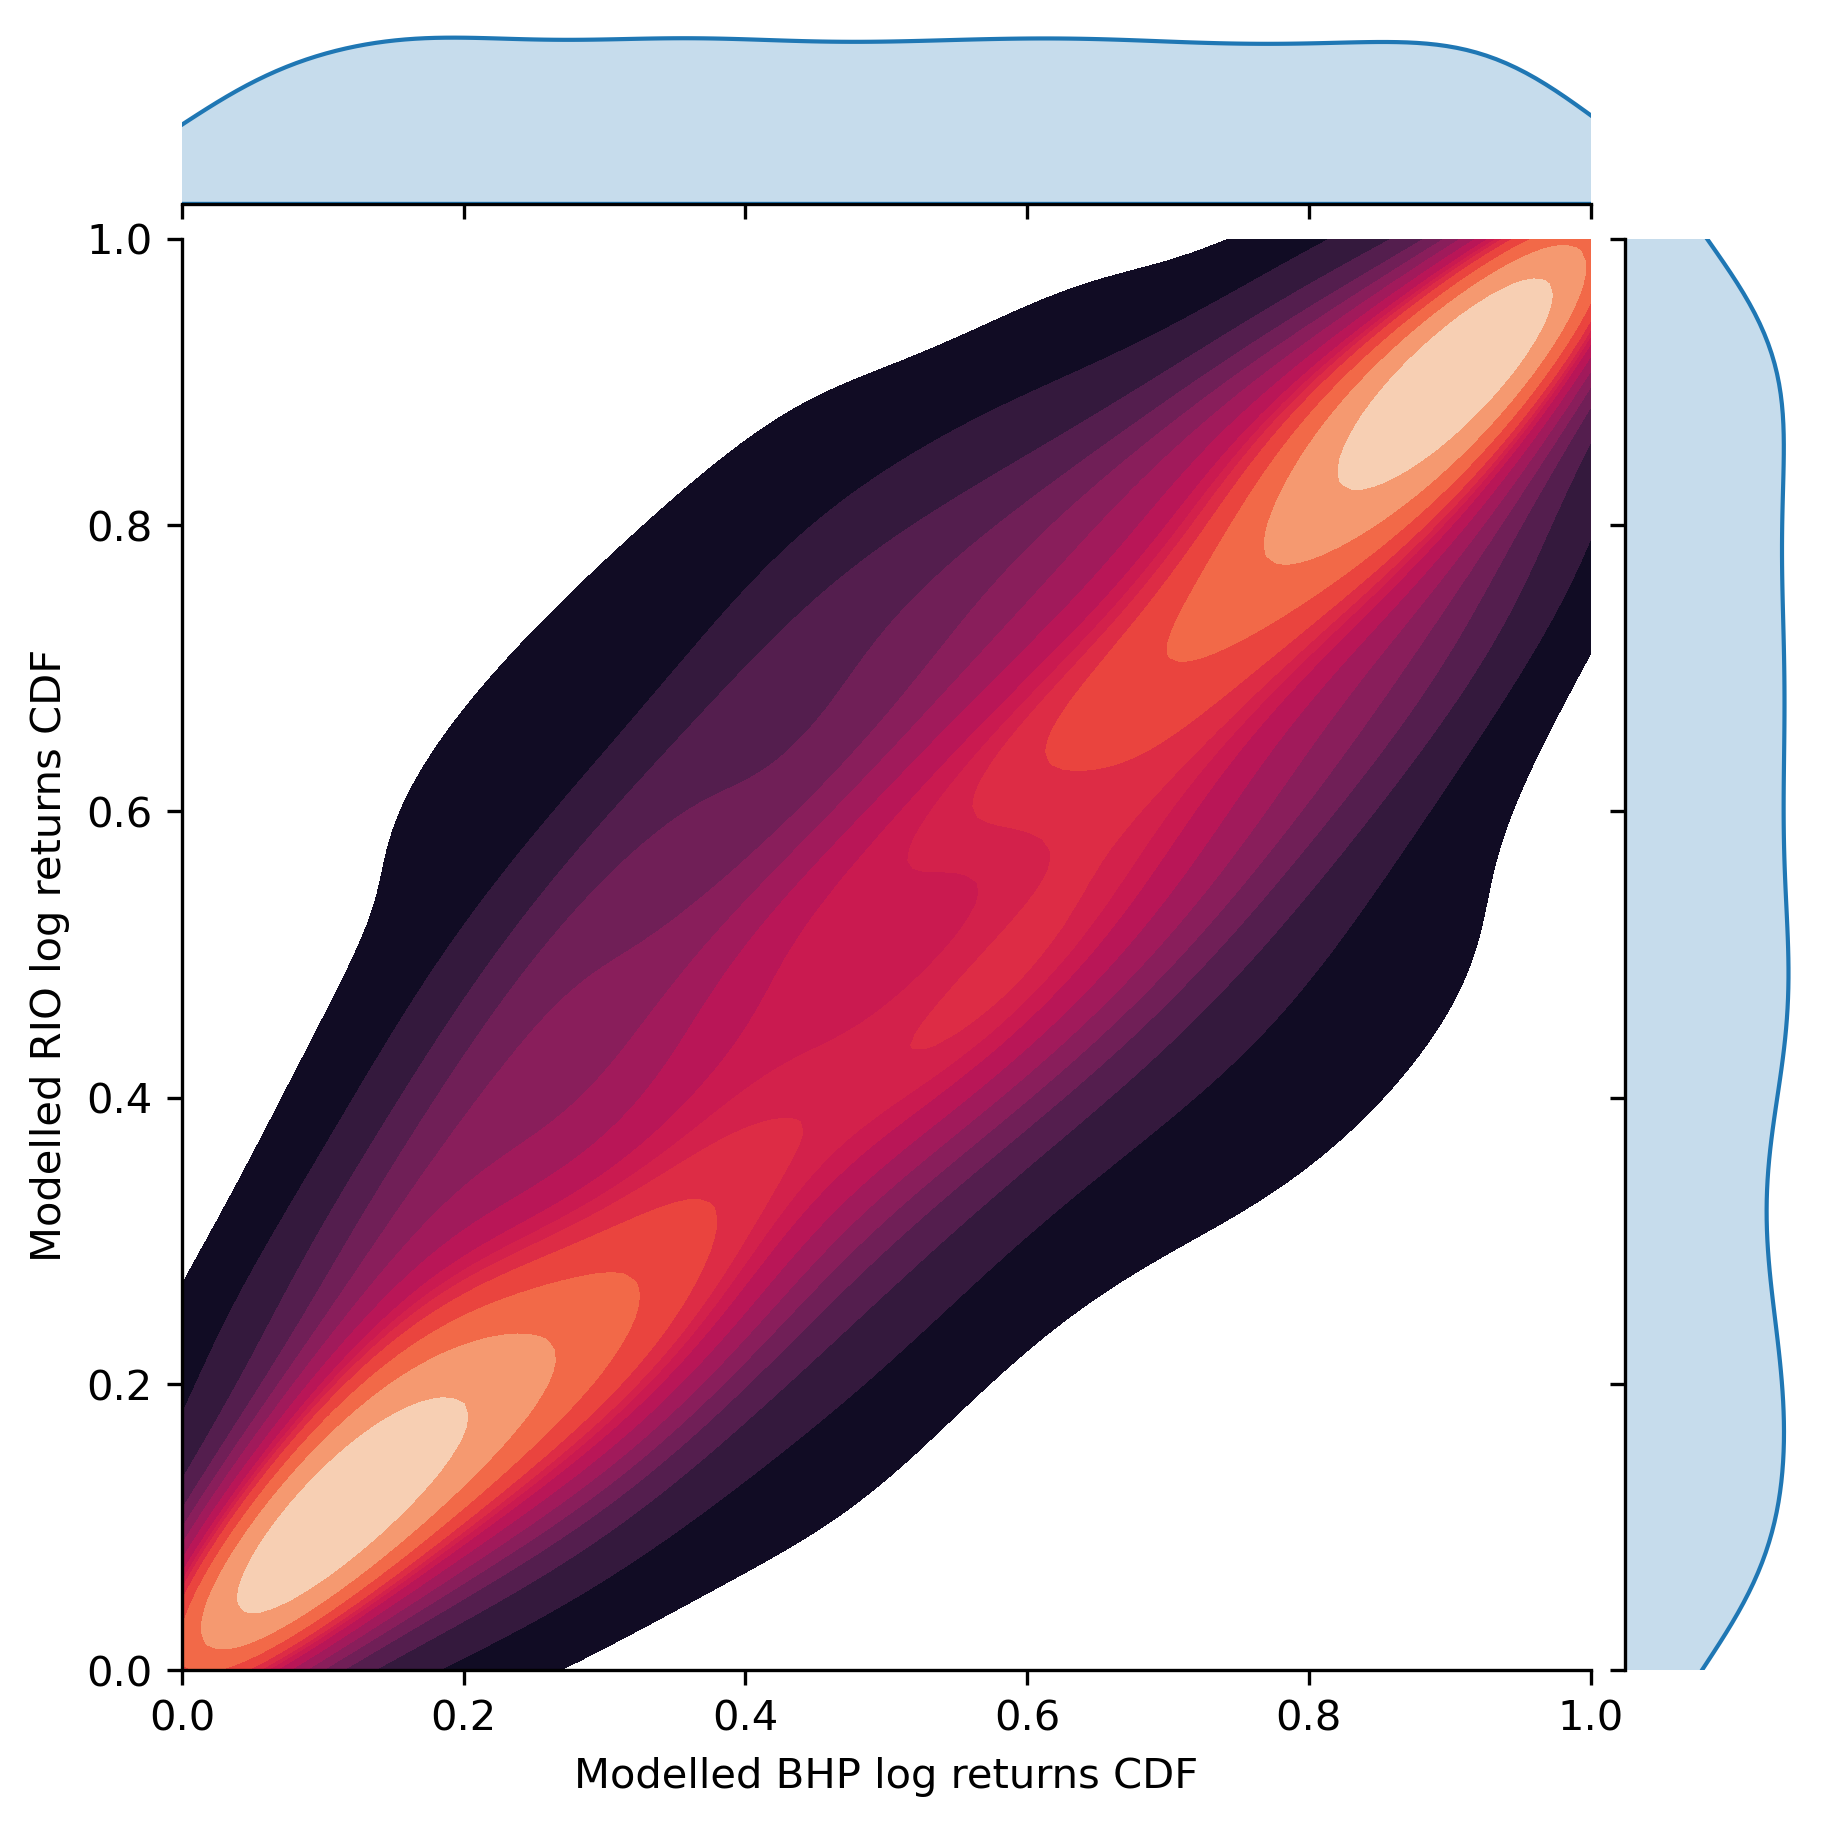

In [14]:
simul = get_model(u).simulate(n=1500)
h = sns.jointplot(x=simul.T[0], y=simul.T[1], kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = h.set_axis_labels("Modelled BHP log returns CDF", "Modelled RIO log returns CDF")

now to create a function to find the mispricing index. This is simply the conditional probability of one stock against another. You can think of it as "how likely is it for stock 1 to be at this price given stock 2 is at this price." Using this, we go off the assumption that the stocks are mean reverting. This means that we assume that if the stock prices drift closer or further than normal, they will return to their "mean" locations relative to each other.

In [15]:
def mispricing_index(model, u):
    MI_v_u = model.hfunc1(u)
    MI_u_v = model.hfunc2(u)
    return MI_u_v, MI_v_u

S1 = data['BHP.AX']
S2 = data['RIO.AX']

# remember that these variables are one less than started
x, y, u = get_variables(S1, S2)

cop = get_model(u)
mispricing_index(cop, u)

(array([0.09940907, 0.6145969 , 0.90263648, ..., 0.15595695, 0.09108665,
        0.56885275]),
 array([0.97457776, 0.25750785, 0.04101141, ..., 0.94312266, 0.80245252,
        0.34966426]))

for example with the mispricing index of u (S1) given v (S2) (`MI_u_v`), if it is above 0.5, S1 is overpriced (meaning we sell S1). If it is below 0.5, S1 is underpriced (we buy S1). This is a simplification, but it is the way I best understood it.

# Strategies

this first strategy is a slightly altered version from the paper "Pairs Trading with Copulas May 3, 2014"

for an understanding of the strategy, I highly recommend reading the paper, or reading an explanation of it from Hudson and Thames

In [16]:
def simulate_trades(S1, S2, lookback=150):
    # Setup stating parametesrs
    # Starting signals
    flagX = 0*S1 # trading indicators
    flagY = 0*S1 

    weightY = 1
    n_X = 0
    n_Y = 0
    n_trades = 0
    returns = 0
    # numbers taken from paper
    D = 0.49 # trigger point from [-0.5, 0.5]
    S = 2 # Stop loss position

    # Series
    rs = 0*S1
    trades = 0*S1
    exits = 0*S1
    MI_x_ys = 0*S1
    MI_y_xs = 0*S1
    copList = []

    for i in range(lookback+1, len(S1), 1):
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]

        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI_x_y, MI_y_x = mispricing_index(cop, u)
        MI_x_ys[i], MI_y_xs[i] = MI_x_y[-1], MI_y_x[-1]
        ## Update copula

        # accumulations of the daily (MI_x_y-0.5) and (MI_y_x-0.5)
        flagX[i] = flagX[i-1] + (MI_x_ys[i]-0.5)
        flagY[i] = flagX[i-1] + (MI_y_xs[i]-0.5)

        #todo may want to make it so the if statement is "reaches", not < or >
        #todo implement stop loss


        #* When FlagX reaches D, we short-sell stock X and buy stock Y in equal amounts.
        #* When FlagY reaches -D, we short-sell stock X and buy stock Y in equal amounts.
        
        if flagX[i] > D or flagY[i] < -D:
            # buy stock Y
            n_Y +=  weightY
            returns -= weightY*S2[i]

            # should you use a proportion?
            # Short sell stock X
            n_X -= weightY
            returns += weightY*S1[i]

            n_trades += 1
            trades[i] = returns + n_X*S1[i] + n_Y*S2[i]

        #? When FlagX reaches -D, we short-sell stock Y and buy stock X in equal amounts.
        #? When FlagY reaches D, we short-sell stock Y and buy stock X in equal amounts.
        elif flagX[i] < -D or flagY[i] > D:
            # short sell stock Y
            n_Y -=  weightY
            returns += weightY*S2[i]

            # should you use a proportion?
            # buy X
            n_X += weightY
            returns -= weightY*S1[i]

            n_trades += 1
            trades[i] = returns + n_X*S1[i] + n_Y*S2[i]
        
        #! If flagX or flagY pass the stop loss, exit all positions
        if abs(flagX[i]) > S or abs(flagY[i]) > S:
            returns += n_X*S1[i] + n_Y*S2[i] 
            n_X = 0
            n_Y = 0

            flagX[i] = 0
            flagY[i] = 0
            exits[i] = returns + n_X*S1[i] + n_Y*S2[i]
        rs[i] = returns + n_X*S1[i] + n_Y*S2[i]
    
    return rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs, trades, exits

# the two stocks we chose
S1 = data['BHP.AX']
S2 = data['RIO.AX']

rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs, trades, exits  = simulate_trades(S1, S2)
n_trades

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_48840/910295986.py:33: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_48840/910295986.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_48840/910295986.py:37: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn800

1778

we can plot the total returns over time for this. Total returns is a combination of the liquid cash in hand, and the value of the stock portfolio.

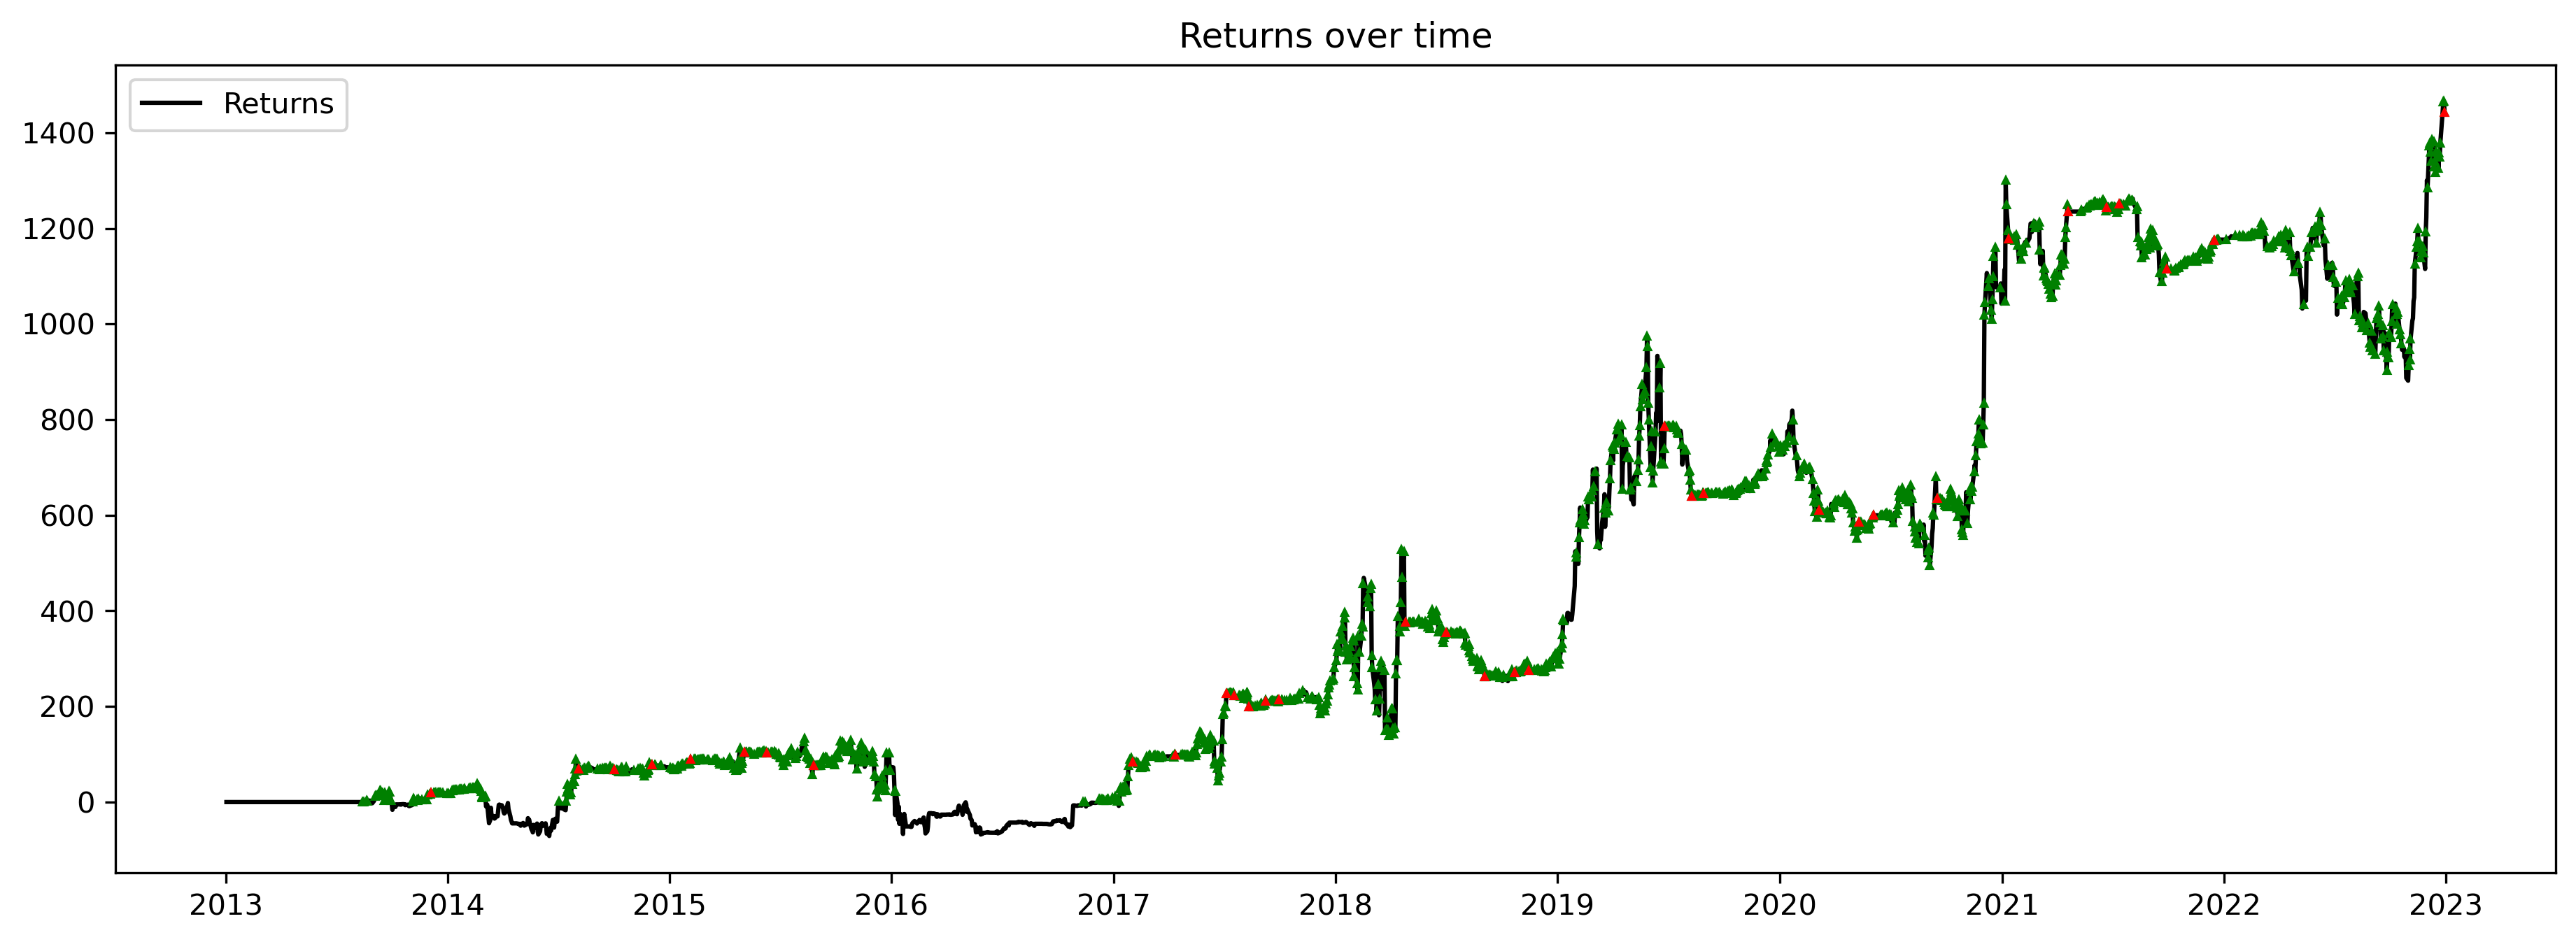

In [22]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(rs, color='black')
plt.plot(trades.where(trades>0), color='green', linestyle='None', marker='^', markersize=2)
plt.plot(exits.where(exits>0), color='red', linestyle='None', marker='^', markersize=2)
plt.legend(['Returns'])
plt.show()

this is what the flags look like over time, when they jump back to 0 is when the stoploss is engaged

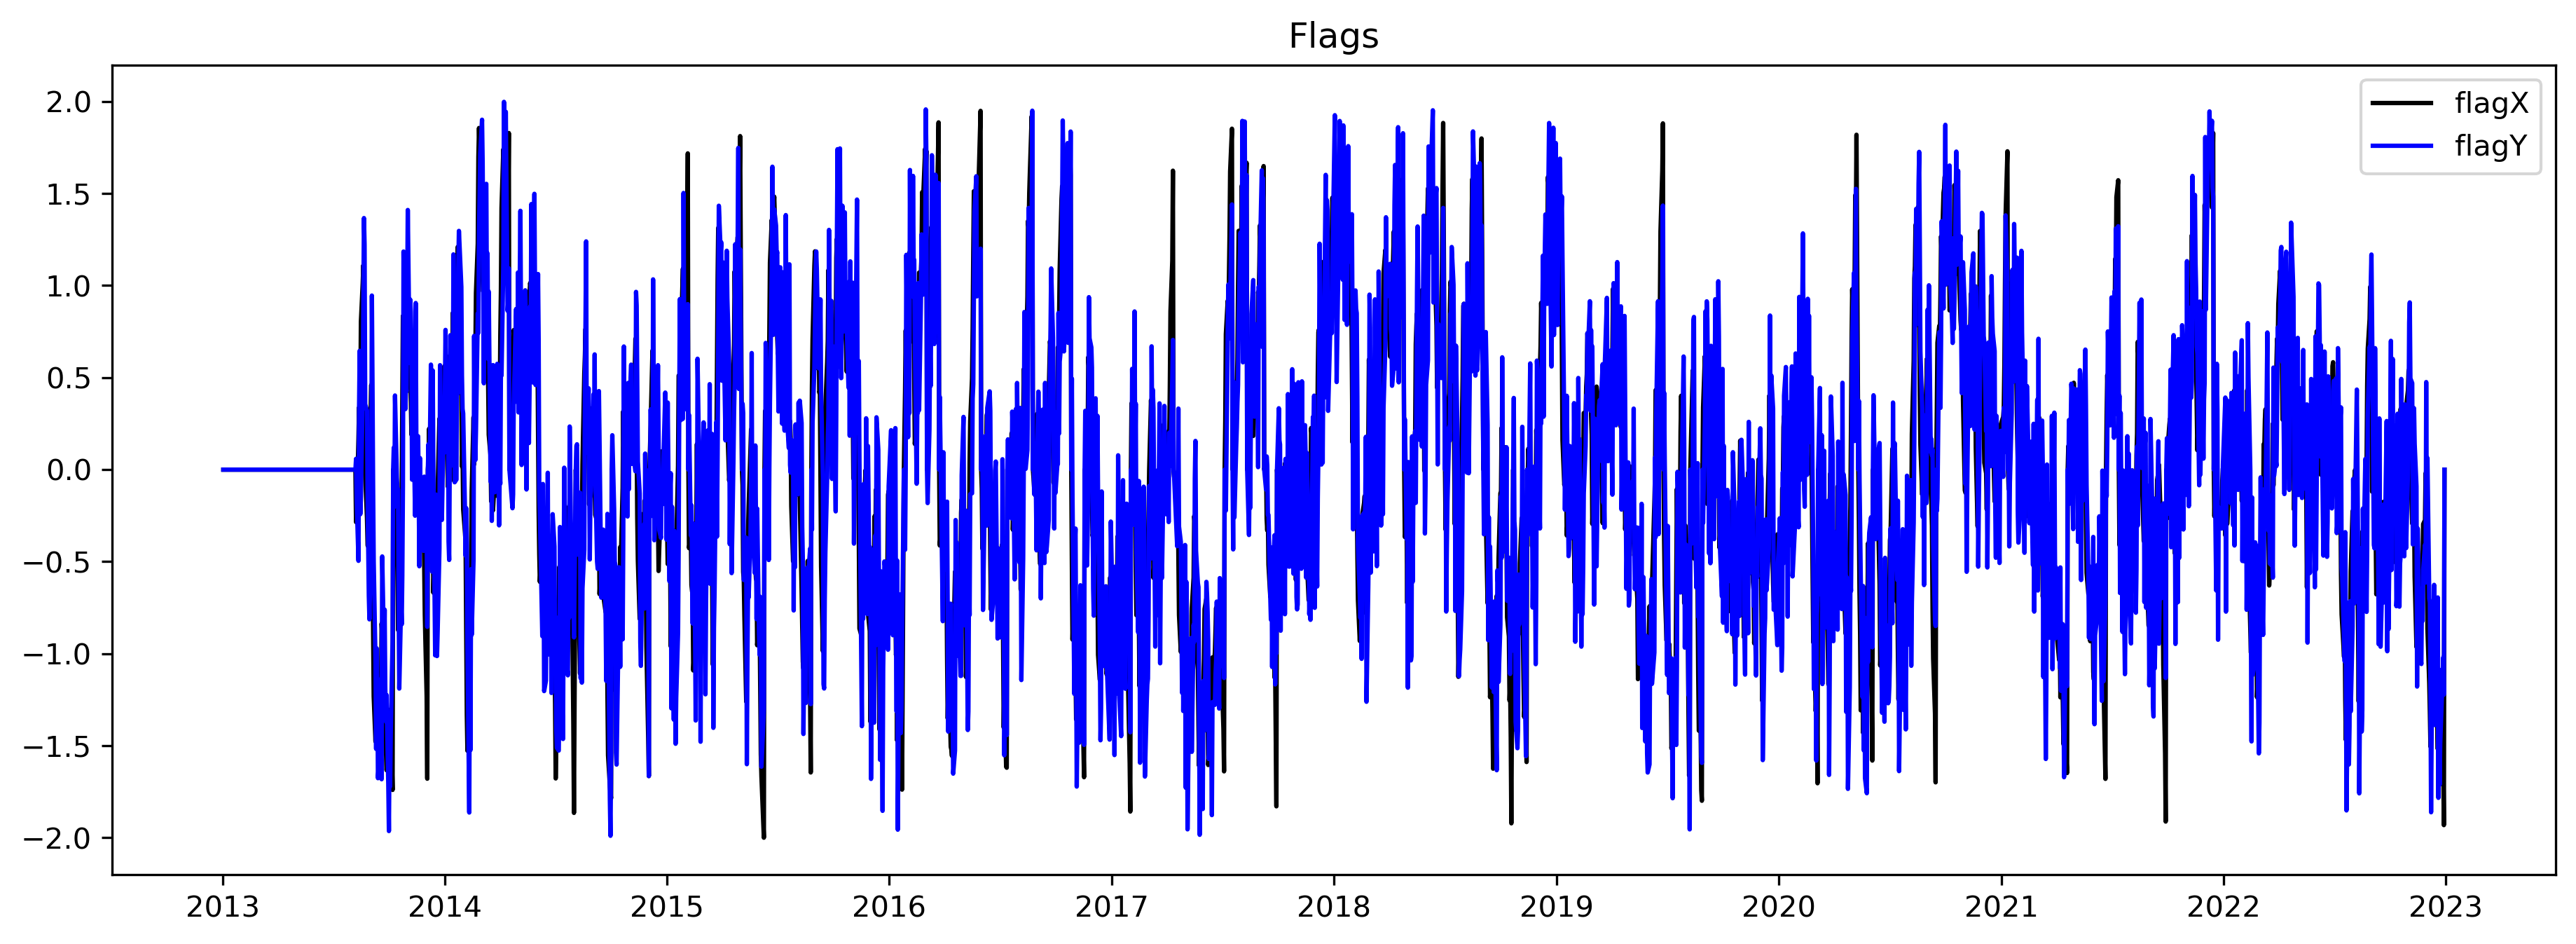

In [ ]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(flagX, color='black')
plt.plot(flagY, color='blue')

plt.legend(['flagX', 'flagY'])
plt.show()

as we can see, this implementation isn't amazing. It could be improved by balancing the stock weight and lookback period windows, and by updating the "best pair" every month for example.


this next strategy is from the paper "Pairs trading: A copula approach" from the 22nd January 2013. this strategy does not opt for the flags.

In [ ]:
def simulate_trades_revised(S1, S2, lookback=150, weight_S2=1):

    ### Trading variables
    upper_CB = 0.95 # upper confidence bound
    lower_CB = 0.05 # lower confidence bound
    EB = 0.5 # Exit bound

    ### Form timeseries
    returns = 0*S1
    totalReturns = 0*S1
    n_S1 = 0*S1
    n_S2 = 0*S1
    MI_u_v = 0*S1 # Mispricing Index of S1 given S2
    MI_v_u = 0*S1 # Mispricing Index of S2 given S1
    copList = []

    ### Testing
    n_trades =0

    for i in range(lookback+1, len(S1), 1): # add 1 to avoid the nan at start

        returns[i] = returns[i-1]
        totalReturns[i] = totalReturns[i-1]

        n_S1[i] = n_S1[i-1]
        n_S2[i] = n_S2[i-1]

        ## Setup the copula
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]
        # log returns
        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI1, MI2 = mispricing_index(cop, u)
        MI_u_v[i], MI_v_u[i] = MI1[-1], MI2[-1]

        # coef = stats.linregress(x, y).slope
        coef = 1
        ## Make trades 
        price_S1, price_S2 = rolling_S1[-1], rolling_S2[-1]
        
        # if S1 is undervalued and S2 is overvalued, go long
        # Sell S2 by weight, and buy S1 by weight * coefficient * long/short price ratio
        if MI_u_v[i] < lower_CB and MI_v_u[i] > upper_CB:
            # sell S2 by weight
            n_S2[i] -= weight_S2
            returns[i] += weight_S2*price_S2
            # buy S1 by weight * coefficient * long/short price ratio
            n_S1[i] += (weight_S2 * coef * (price_S1/price_S2))
            returns[i] -= (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            # buy[i] = price_S1
            # sell[i] = price_S2

            n_trades += 1

        # Buy S2 by weight, sell S1 by weight * coefficient * long/short price ratio
        elif MI_u_v[i] > lower_CB and MI_v_u[i] < upper_CB:
            # buy S2 by weight
            n_S2[i] += weight_S2
            returns[i] -= weight_S2*price_S2
            # sell S1 by weight * coefficient * long/short price ratio
            n_S1[i] -= (weight_S2 * coef * (price_S1/price_S2))
            returns[i] += (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            # sell[i] = price_S1
            # buy[i] = price_S2

            n_trades += 1

        # if it crosses the exit threshold, liquidate positions
        elif ((MI_u_v[i] < EB and MI_u_v[i-1] > EB) or (MI_u_v[i] > EB and MI_u_v[i-1] < EB)) \
         and ((MI_v_u[i] < EB and MI_v_u[i-1] > EB) or (MI_v_u[i] > EB and MI_v_u[i-1] < EB)):
            
            returns[i] += n_S1[i]*price_S1 + n_S2[i]*price_S2
            n_S1[i] = 0
            n_S2[i] = 0

            # liquidateS1[i] = price_S1
            # liquidateS2[i] = price_S2

        totalReturns[i] = returns[i] + n_S1[i]*price_S1 + n_S2[i]*price_S2

    return totalReturns, n_S1, n_S2, MI_u_v, MI_v_u, copList, n_trades


S1 = data['BHP.AX']
S2 = data['RIO.AX']

totalReturns, n_S1, n_S2, MI_u_v, MI_v_u, copList, n_trades = simulate_trades_revised(S1, S2)
n_trades

2270

total returns over time

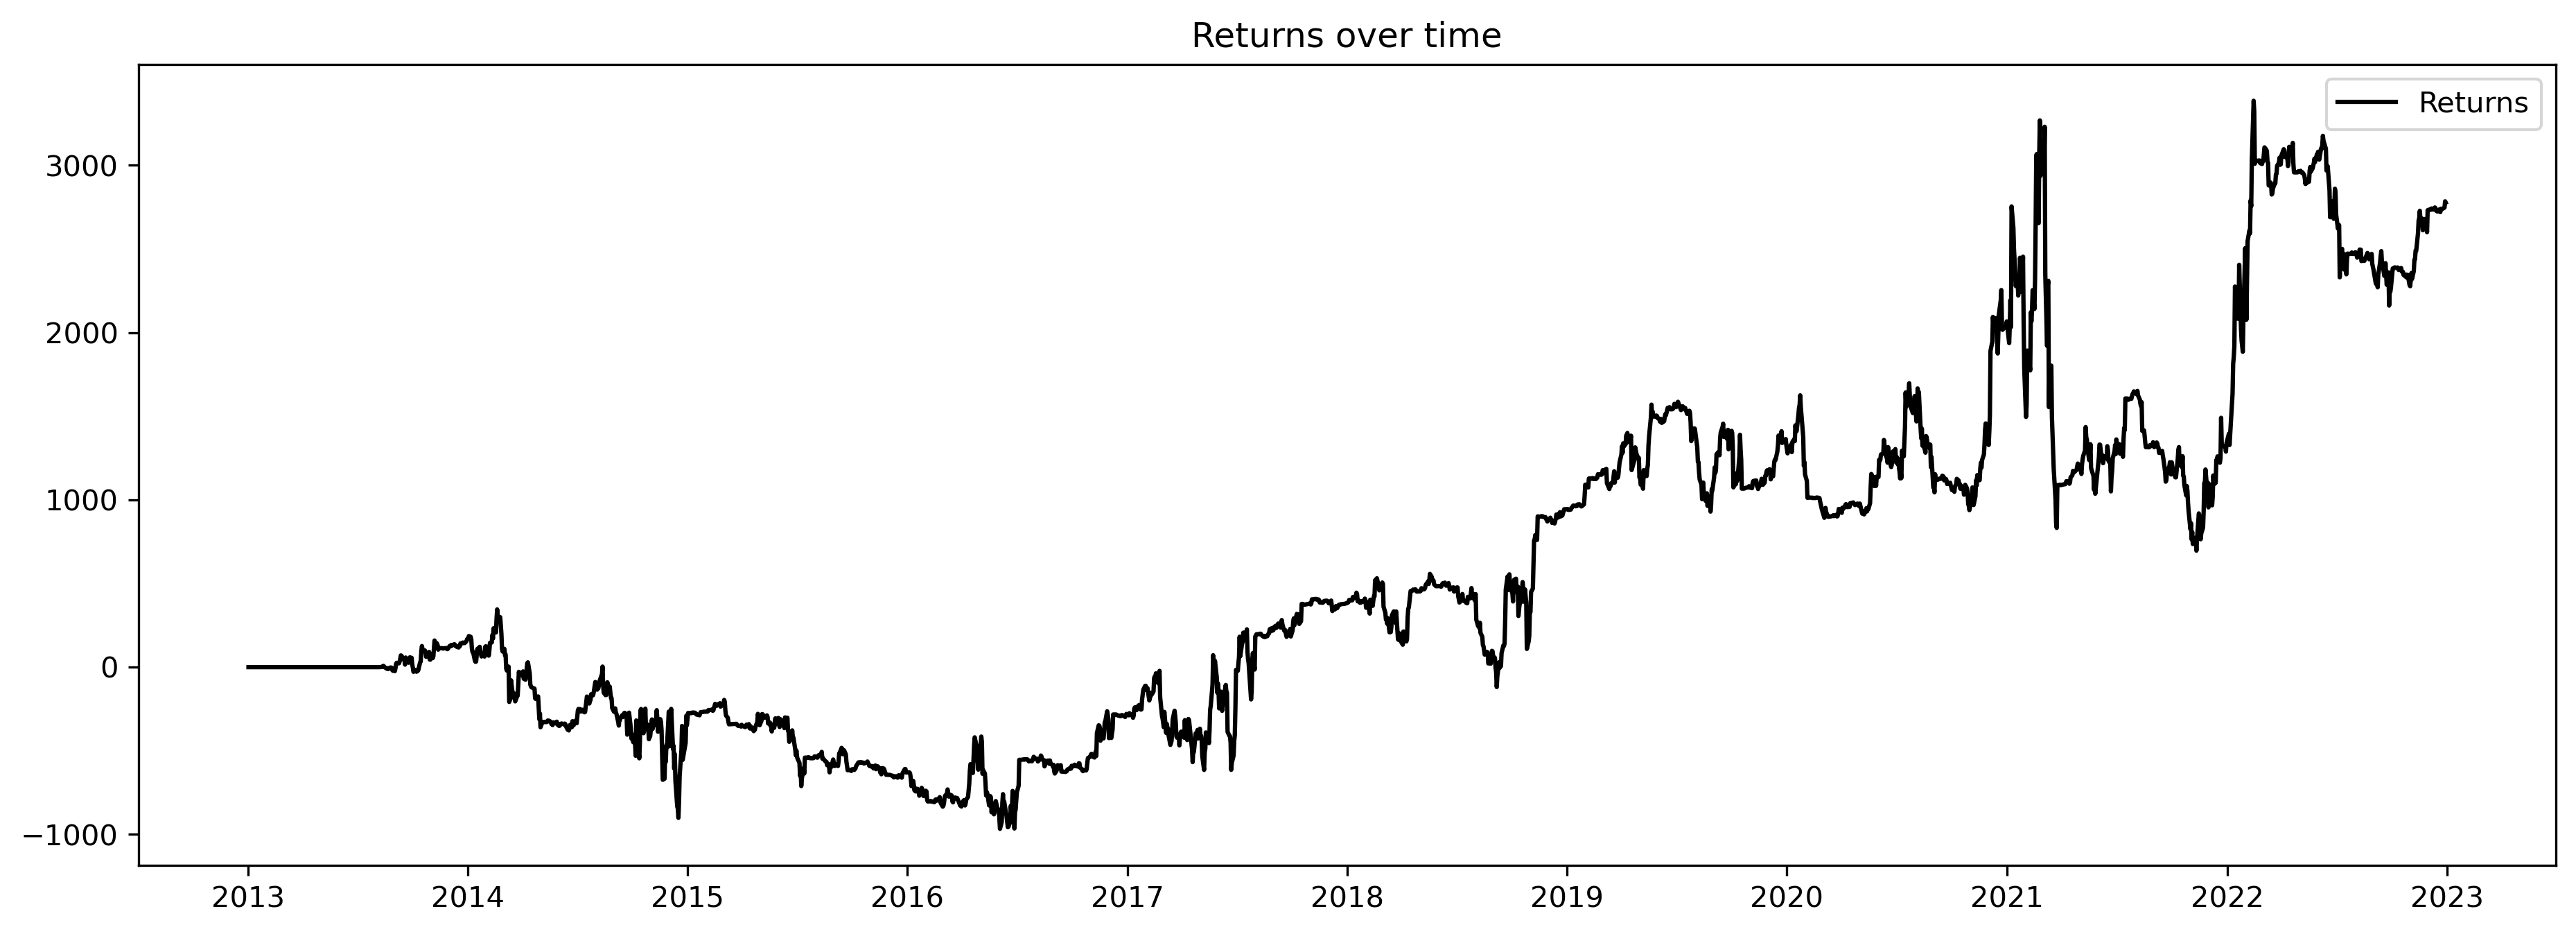

In [ ]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(totalReturns, color='black')
plt.legend(['Returns'])
plt.show()

this is the mispricing indices over time

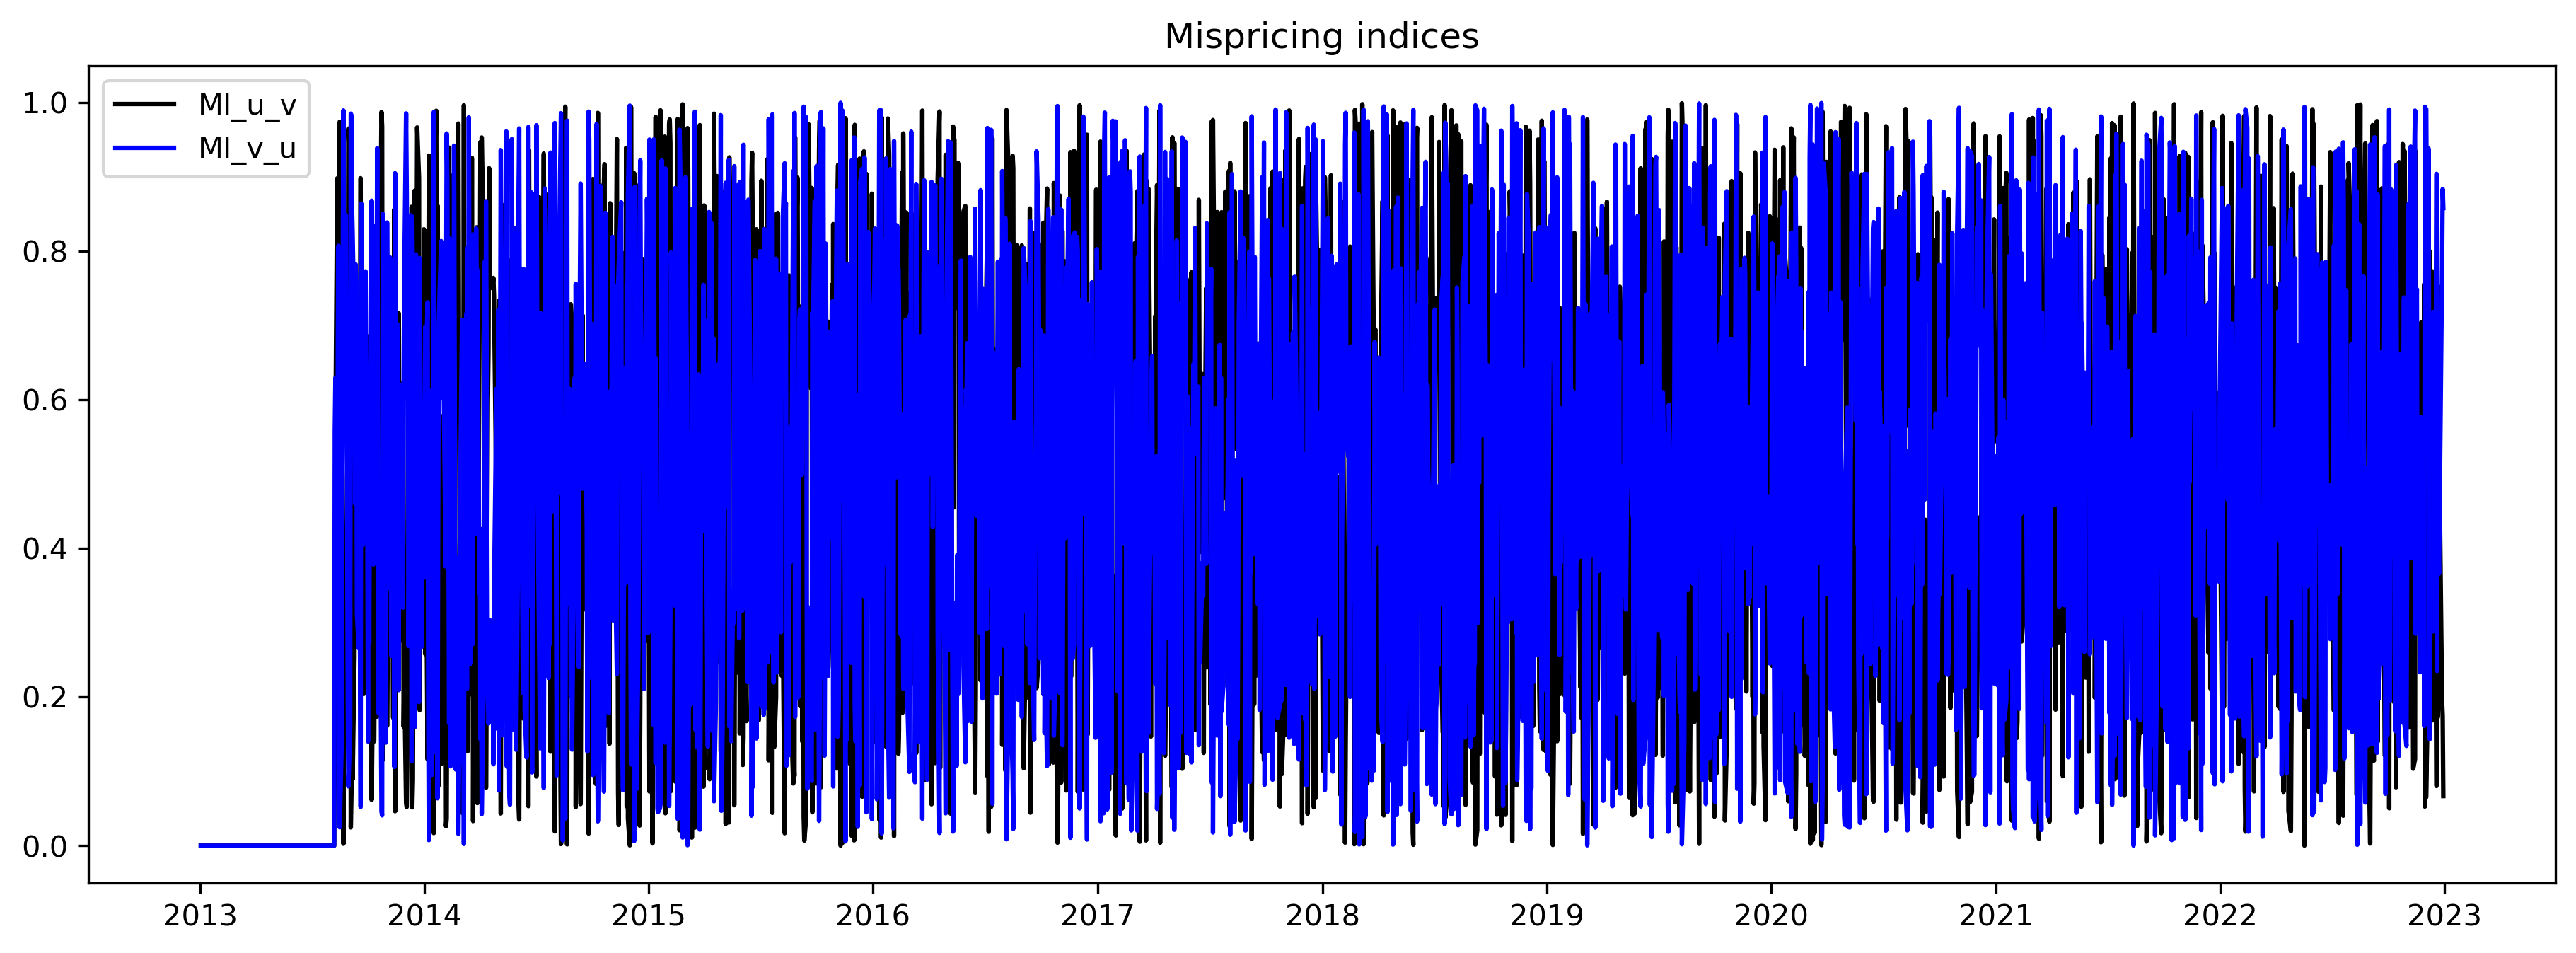

In [ ]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Mispricing indices")
plt.plot(MI_u_v, color='black')
plt.plot(MI_v_u, color='blue')

plt.legend(['MI_u_v', 'MI_v_u'])
plt.show()

this strategy performs better, however also seems to have significant risk involved. It would benefit from the same improvements as the previous strategy

Variation by Rad et al (2016) (altered)

In [25]:
def simulate_trades(S1, S2, lookback=150):
    # Setup stating parametesrs
    # Starting signals
    flagX = 0*S1 # trading indicators
    flagY = 0*S1 

    weightY = 1
    n_X = 0
    n_Y = 0
    n_trades = 0
    returns = 0
    # numbers taken from paper
    D = 0.49 # trigger point from [-0.5, 0.5]
    S = 2 # Stop loss position

    # Series
    rs = 0*S1
    trades = 0*S1
    exits = 0*S1
    MI_x_ys = 0*S1
    MI_y_xs = 0*S1
    copList = []

    for i in range(lookback+1, len(S1), 1):
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]

        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI_x_y, MI_y_x = mispricing_index(cop, u)
        MI_x_ys[i], MI_y_xs[i] = MI_x_y[-1], MI_y_x[-1]
        ## Update copula

        # accumulations of the daily (MI_x_y-0.5) and (MI_y_x-0.5)
        flagX[i] = flagX[i-1] + (MI_x_ys[i]-0.5)
        flagY[i] = flagX[i-1] + (MI_y_xs[i]-0.5)

        #todo may want to make it so the if statement is "reaches", not < or >
        #todo implement stop loss


        #* When FlagX reaches D, we short-sell stock X and buy stock Y in equal amounts.
        #* When FlagY reaches -D, we short-sell stock X and buy stock Y in equal amounts.
        
        if flagX[i] > D or flagY[i] < -D:
            # buy stock Y
            n_Y +=  weightY
            returns -= weightY*S2[i]

            # should you use a proportion?
            # Short sell stock X
            n_X -= weightY
            returns += weightY*S1[i]

            n_trades += 1
            trades[i] = returns + n_X*S1[i] + n_Y*S2[i]

        #? When FlagX reaches -D, we short-sell stock Y and buy stock X in equal amounts.
        #? When FlagY reaches D, we short-sell stock Y and buy stock X in equal amounts.
        elif flagX[i] < -D or flagY[i] > D:
            # short sell stock Y
            n_Y -=  weightY
            returns += weightY*S2[i]

            # should you use a proportion?
            # buy X
            n_X += weightY
            returns -= weightY*S1[i]

            n_trades += 1
            trades[i] = returns + n_X*S1[i] + n_Y*S2[i]
        
        #! If flagX or flagY pass the stop loss, exit all positions
        if abs(flagX[i]) > S or abs(flagY[i]) > S:
            returns += n_X*S1[i] + n_Y*S2[i] 
            n_X = 0
            n_Y = 0

            # flagX[i] = 0
            # flagY[i] = 0
            exits[i] = returns + n_X*S1[i] + n_Y*S2[i]
        rs[i] = returns + n_X*S1[i] + n_Y*S2[i]
    
    return rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs, trades, exits

# the two stocks we chose
S1 = data['BHP.AX']
S2 = data['RIO.AX']

rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs, trades, exits  = simulate_trades(S1, S2)
n_trades

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_48840/1001593655.py:33: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_48840/1001593655.py:37: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_48840/1001593655.py:37: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn

2260

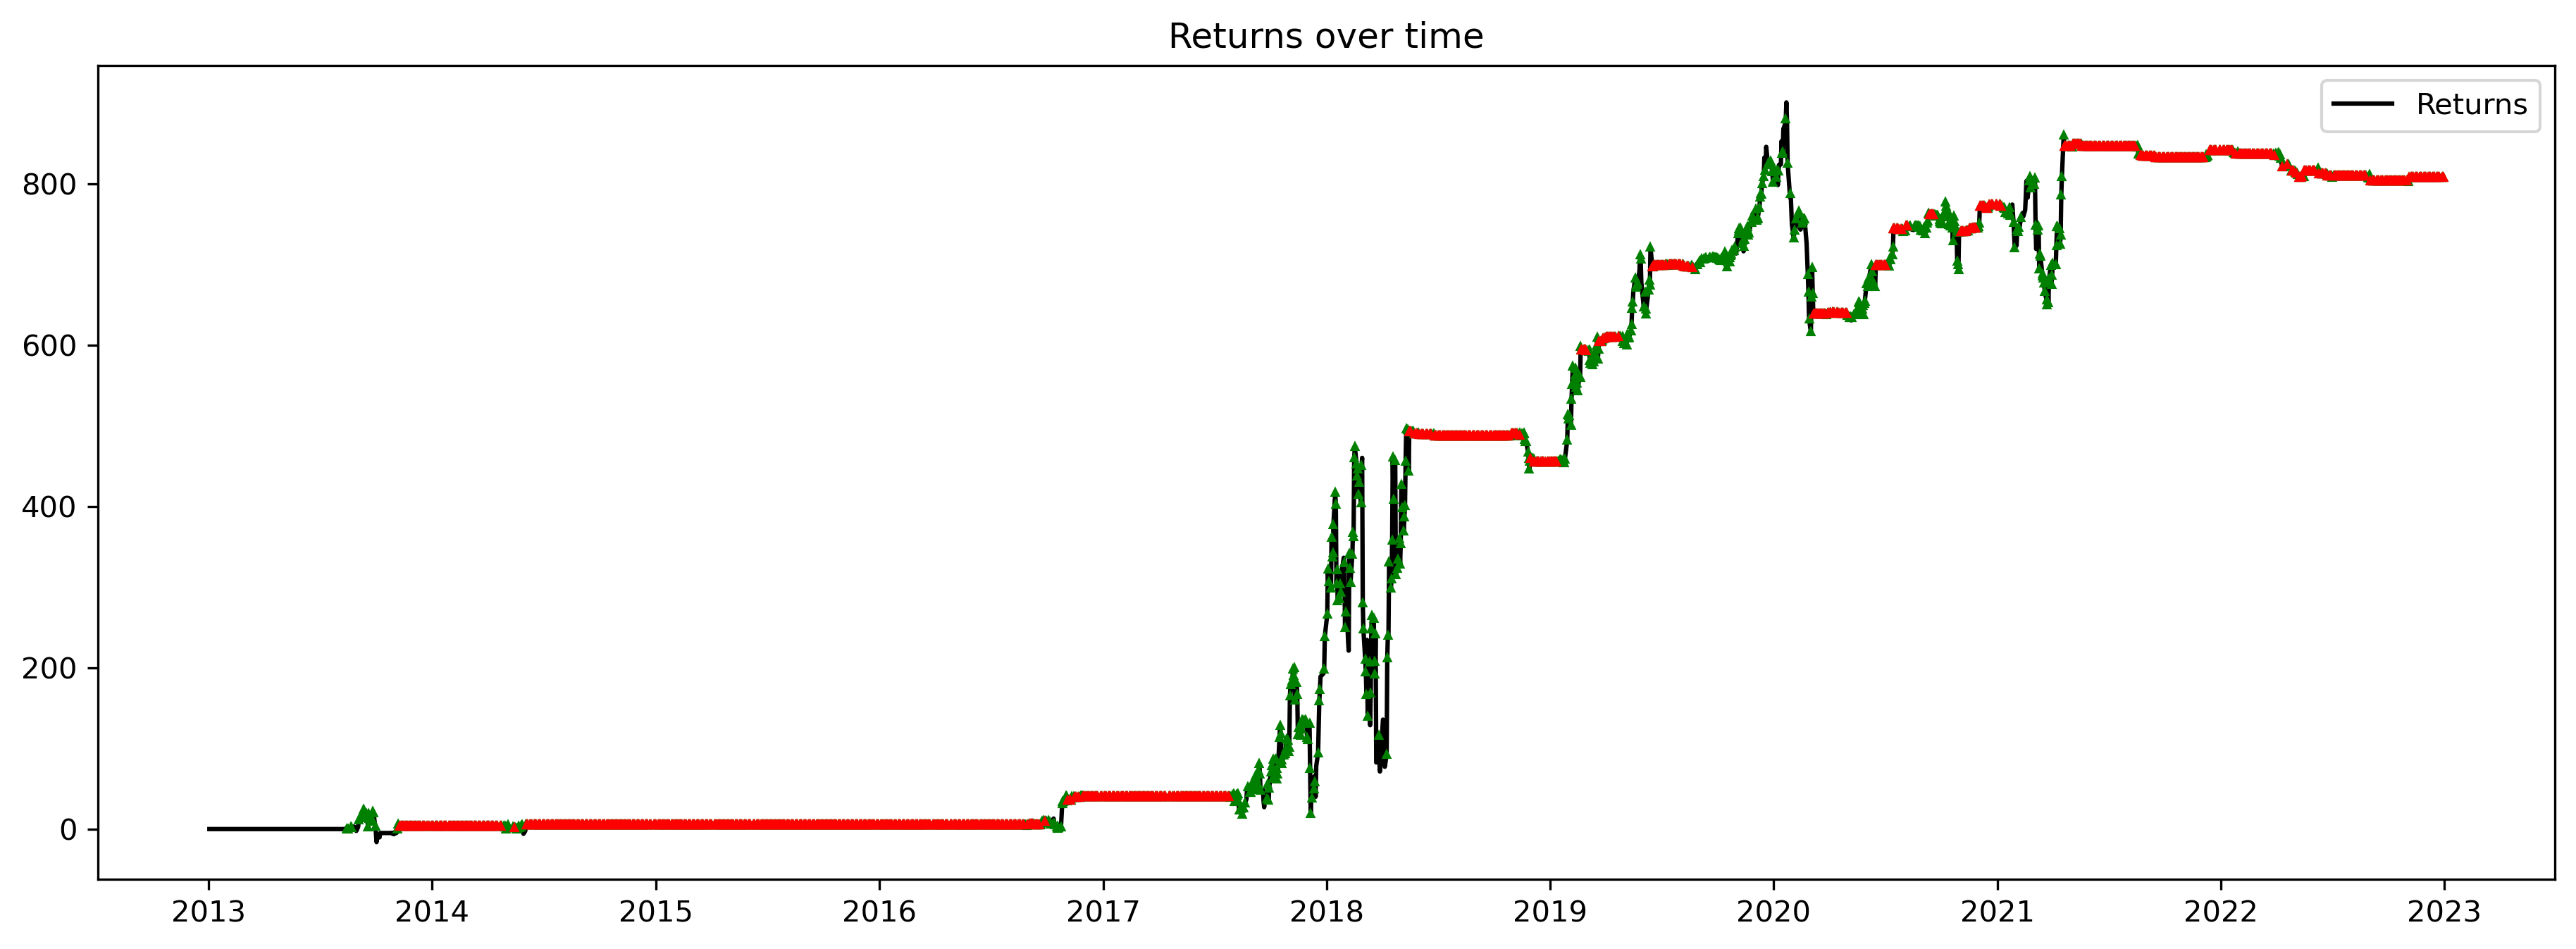

In [26]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time")
plt.plot(rs, color='black')
plt.plot(trades.where(trades>0), color='green', linestyle='None', marker='^', markersize=2)
plt.plot(exits.where(exits>0), color='red', linestyle='None', marker='^', markersize=2)
plt.legend(['Returns'])
plt.show()

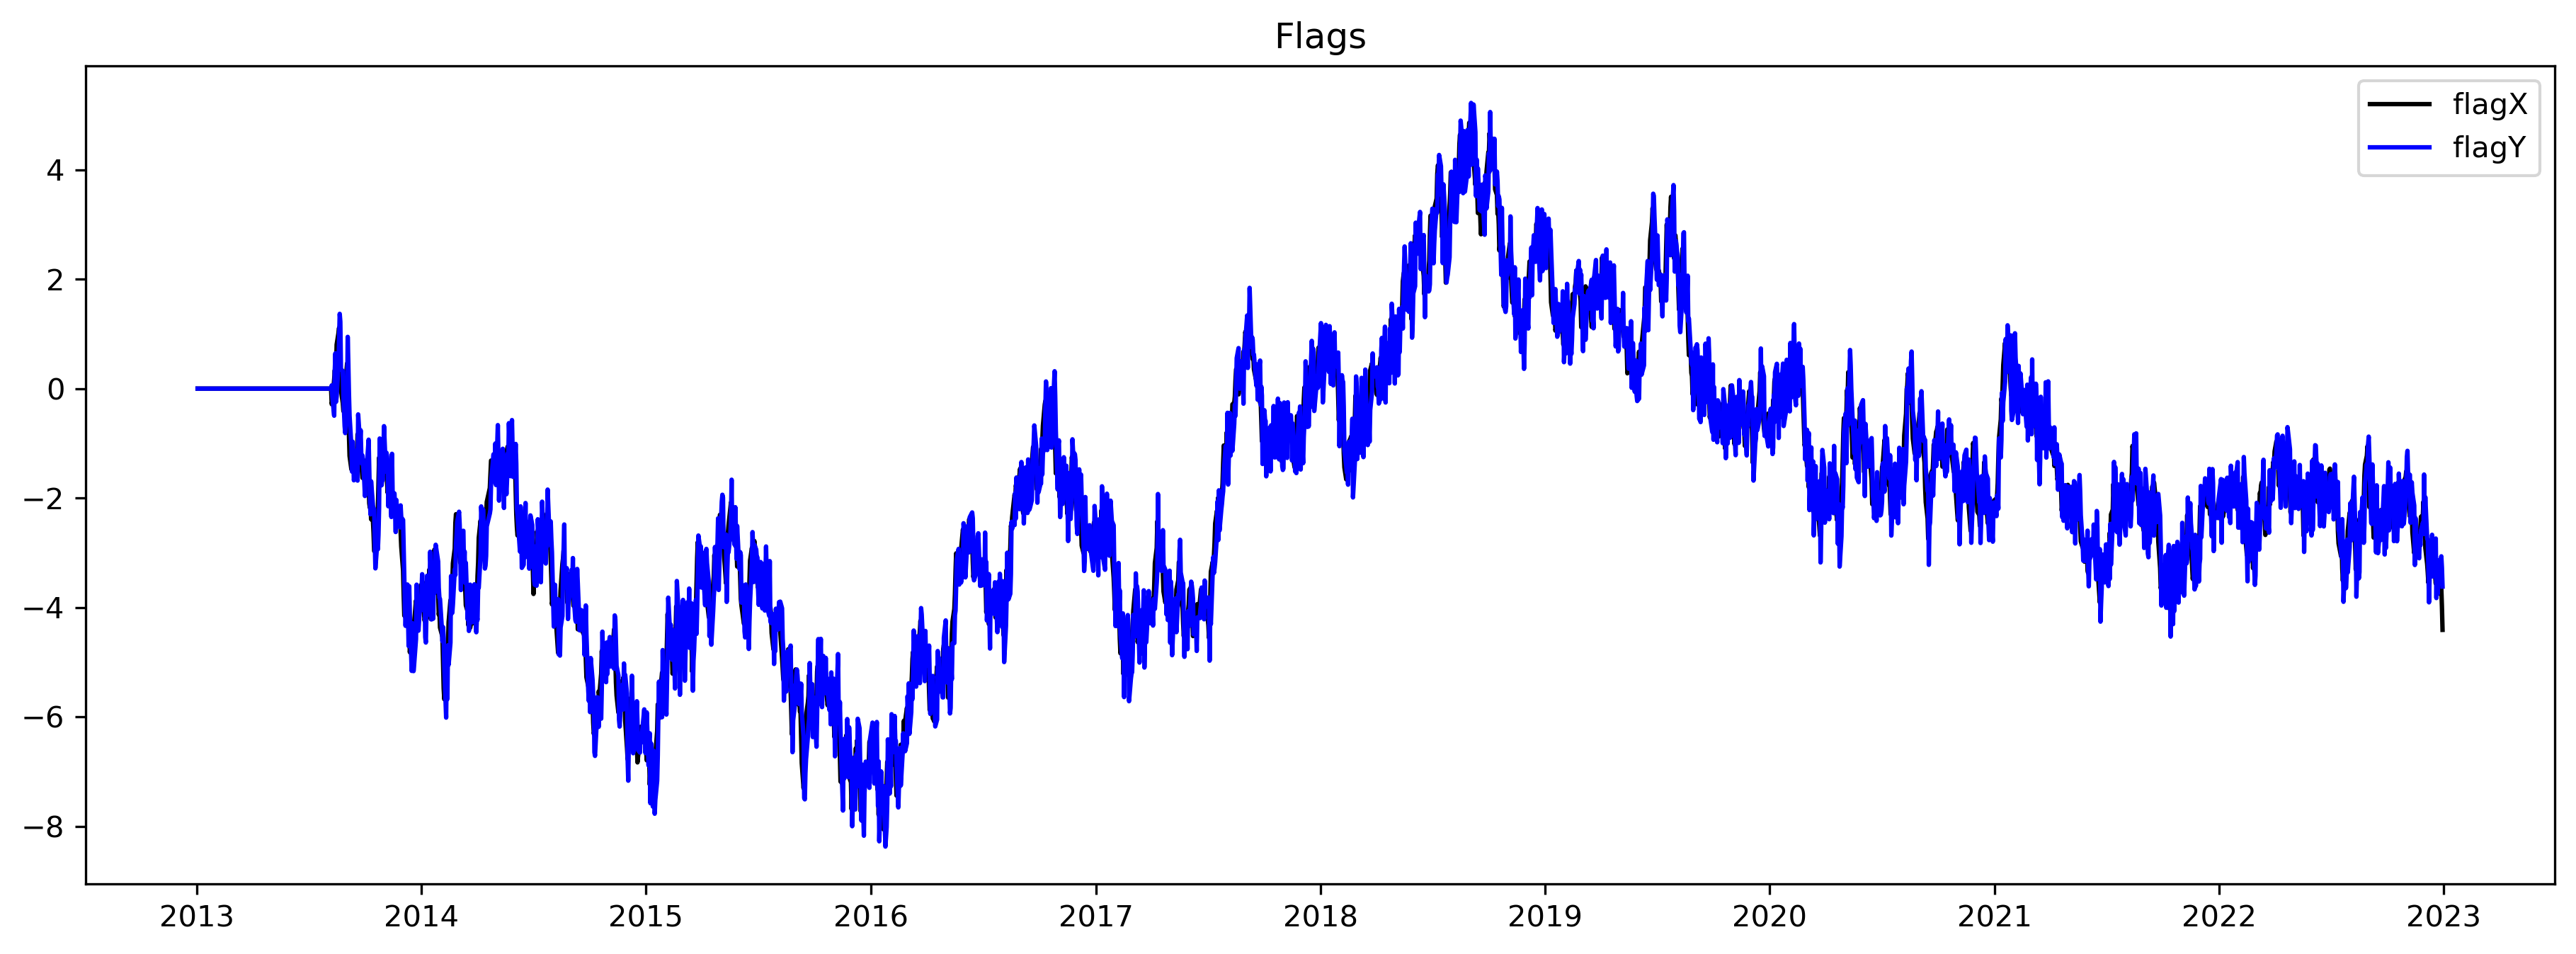

In [27]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(flagX, color='black')
plt.plot(flagY, color='blue')

plt.legend(['flagX', 'flagY'])
plt.show()